In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
images_dir = '/content/drive/MyDrive/AdvancedML/Homework1/Fig2.13/'

# Logistic regression on the iris flower dataset

In [4]:
# Code is based on Aurélien Geron's code
# https://github.com/ageron/handson-ml2/blob/master/04_training_linear_models.ipynb

import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn import datasets
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import train_test_split

from ipywidgets import interact, FloatSlider, fixed

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled

# from probml_utils import LogisticRegression as lr
import probml_utils.LogisticRegression as lr

# Load datset
iris = datasets.load_iris()

     |████████████████████████████████| 145 kB 21.6 MB/s 
     |████████████████████████████████| 85 kB 3.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 272 kB 39.8 MB/s 
     |████████████████████████████████| 128 kB 44.0 MB/s 
     |████████████████████████████████| 88 kB 6.5 MB/s 
     |████████████████████████████████| 120 kB 62.5 MB/s 
     |████████████████████████████████| 1.6 MB 38.1 MB/s 
     |████████████████████████████████| 82 kB 784 kB/s 
     |████████████████████████████████| 1.1 MB 46.2 MB/s 


In [5]:
latexify(width_scale_factor=1.1, fig_height=1.5)
SCATTER_SIZE = 10 if is_latexify_enabled() else None

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:25: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


/usr/local/lib/python3.7/dist-packages/matplotlib/patches.py:1327: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  verts = np.dot(coords, M) + (x + dx, y + dy)


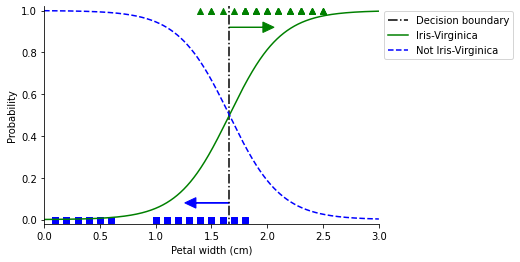

In [6]:
########################
# Fig 2.11
# Initially use 1 feature, 2 classes

x = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(jnp.int32)  # 1 if Iris-Virginica, else 0'

parameters = lr.fit(x, y, lambd=1)

x_new = jnp.linspace(0, 3, 1000).reshape(-1, 1)
y_prob = lr.predict_proba(parameters[0], x_new)
decision_boundary = x_new[y_prob > 0.5][0]

plt.figure()
plt.scatter(x[y == 0], y[y == 0], s=SCATTER_SIZE, c="b", marker="s")
plt.scatter(x[y == 1], y[y == 1], s=SCATTER_SIZE, c="g", marker="^")
plt.plot(
    [decision_boundary, decision_boundary],
    [-1, 2],
    color="black",
    linestyle="-.",
    label="Decision boundary",
)
plt.plot(x_new, y_prob, "g-", label="Iris-Virginica")
plt.plot(x_new, 1 - y_prob, "b--", label="Not Iris-Virginica")

plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc="g", ec="g")

plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend(bbox_to_anchor=(1, 1))
plt.axis([0, 3, -0.02, 1.02])
sns.despine()
# savefig("iris-logreg-1d.pdf")
plt.savefig(f"{images_dir}/iris-logreg-1d.png")

(150, 2)


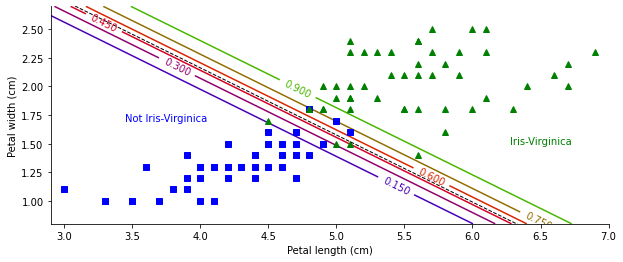

In [7]:
########################
# Now use 2 features, 2 classes
# Train Data
# petal length, petal width
train_x = iris["data"][:, (2, 3)]

# 1 if Iris-Virginica, else 0
train_y = (iris["target"] == 2).astype(jnp.int32)

print(train_x.shape)


# Fit model
parameters = lr.fit(train_x, train_y, lambd=0.01)


# Test data

# # Generate values for petal length and petal width
test_featvec_x0, test_featvec_x1 = jnp.meshgrid(
    jnp.linspace(2.9, 7, 500),
    jnp.linspace(0.8, 2.7, 200),
)

# Plot data
if is_latexify_enabled():
    fig, ax = plt.subplots(1, 1)
    ax.plot(train_x[train_y == 0, 0], train_x[train_y == 0, 1], "bs", markersize=1.5)
    ax.plot(train_x[train_y == 1, 0], train_x[train_y == 1, 1], "g^", markersize=1.5)
else:
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(train_x[train_y == 0, 0], train_x[train_y == 0, 1], "bs")
    ax.plot(train_x[train_y == 1, 0], train_x[train_y == 1, 1], "g^")

# Combine new values of petal length, petal width
test_x = jnp.c_[test_featvec_x0.ravel(), test_featvec_x1.ravel()]

# Predict probabilities
y_pred_proba = lr.predict_proba(parameters[0], test_x)

# Choose probability for label Iris-Virginica
prob_iris_virginca = y_pred_proba.reshape(test_featvec_x0.shape)
# Contour plot

contour = ax.contour(test_featvec_x0, test_featvec_x1, prob_iris_virginca, cmap=plt.cm.brg)

# Create decision boundary
bounds_test_x0 = jnp.array([2.9, 7])
decision_boundary = -(parameters[2][0] * bounds_test_x0 + parameters[1]) / parameters[2][1]

ax.plot(bounds_test_x0, decision_boundary, "k--", linewidth=1)
ax.text(3.75, 1.70, "Not Iris-Virginica", color="b", ha="center")
ax.text(6.5, 1.5, "Iris-Virginica", color="g", ha="center")
ax.set_xlabel("Petal length (cm)")
ax.set_ylabel("Petal width (cm)")
ax.axis([2.9, 7, 0.8, 2.7])
# savefig("iris-logreg-2d-2class")
plt.savefig(f"{images_dir}/iris-logreg-2d-class.png")
ax.clabel(contour, inline=1)
sns.despine()
plt.show()

In [8]:
def contour_loss(w0, w1, bias):
    test_parameters = jnp.array([bias, w0, w1])
    x = jnp.concatenate([jnp.ones([train_x.shape[0], 1]), train_x], axis=1)

    return lr.binary_loss_function(test_parameters, [x, train_y, 0.1])[0]

In [9]:
n = 10
weight0 = jnp.linspace(3, 8, n)
weight1 = jnp.linspace(7, 11, n)
grid_losses = jnp.zeros((n, n))
for i in range(n):
    for j in range(n):
        loss = contour_loss(weight0[i], weight1[j], parameters[1])
        grid_losses = grid_losses.at[i, j].set(loss)
x, y = jnp.meshgrid(weight0, weight1)


def draw_plots(weight0, weight1, x, y, parameters, train_x, train_y):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"width_ratios": [3, 2.3]})

    ax[0].plot(train_x[train_y == 0, 0], train_x[train_y == 0, 1], "bs")
    ax[0].plot(train_x[train_y == 1, 0], train_x[train_y == 1, 1], "g^")

    bounds_test_x0 = jnp.array([2.9, 7])
    decision_boundary = -(weight0 * bounds_test_x0 + parameters[1]) / weight1

    ax[0].plot(bounds_test_x0, decision_boundary, "k--")
    ax[0].text(3.75, 1.70, "Not Iris-Virginica", color="b", ha="center")
    ax[0].text(6.5, 1.5, "Iris-Virginica", color="g", ha="center")
    ax[0].set_xlabel("Petal length (cm)")
    ax[0].set_ylabel("Petal width (cm)")
    ax[0].axis([2.9, 7, 0.8, 2.7])
    # contour_poat
    CS = ax[1].contourf(x, y, grid_losses, alpha=0.7, cmap="viridis")
    ax[1].plot(weight0, weight1, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="red")
    plt.contour(x, y, grid_losses, levels=50, linewidths=0.5, colors="black")
    props = dict(boxstyle="round", facecolor="white", alpha=0.5)
    loss = contour_loss(weight0, weight1, parameters[1])
    txt = f"Loss : %0.2f" % (loss)
    ax[1].text(0, 1.1, txt, verticalalignment="top", transform=ax[1].transAxes, bbox=props, fontsize=15)
    sns.despine()
    plt.colorbar(CS)
    plt.show()


w0 = FloatSlider(
    min=parameters[2][0] - 1.5,
    max=parameters[2][0] + 1.5,
    step=0.5,
    value=parameters[2][0],
)
w1 = FloatSlider(
    min=parameters[2][1] - 1.5,
    max=parameters[2][1] + 1.5,
    step=0.5,
    value=parameters[2][1],
)

interact(
    draw_plots,
    weight0=w0,
    weight1=w1,
    x=fixed(x),
    y=fixed(y),
    parameters=fixed(parameters),
    train_x=fixed(train_x),
    train_y=fixed(train_y),
)

interactive(children=(FloatSlider(value=5.420770168304443, description='weight0', max=6.920770168304443, min=3…

<function __main__.draw_plots(weight0, weight1, x, y, parameters, train_x, train_y)>

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:25: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


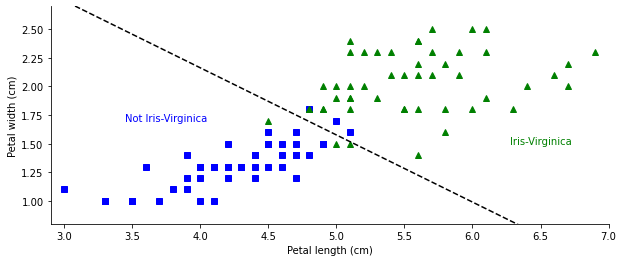

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:25: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [10]:
latexify(width_scale_factor=2, fig_height=1.25, font_size=8)

if is_latexify_enabled():
    fig, ax = plt.subplots(1, 1)
    ax.plot(train_x[train_y == 0, 0], train_x[train_y == 0, 1], "bs", markersize=1.5)
    ax.plot(train_x[train_y == 1, 0], train_x[train_y == 1, 1], "g^", markersize=1.5)
else:
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(train_x[train_y == 0, 0], train_x[train_y == 0, 1], "bs")
    ax.plot(train_x[train_y == 1, 0], train_x[train_y == 1, 1], "g^")

bounds_test_x0 = jnp.array([2.9, 7])
decision_boundary = -(parameters[2][0] * bounds_test_x0 + parameters[1]) / parameters[2][1]

ax.plot(bounds_test_x0, decision_boundary, "k--")
ax.text(3.75, 1.70, "Not Iris-Virginica", color="b", ha="center")
ax.text(6.5, 1.5, "Iris-Virginica", color="g", ha="center")
ax.set_xlabel("Petal length (cm)")
ax.set_ylabel("Petal width (cm)")
ax.axis([2.9, 7, 0.8, 2.7])
sns.despine()
# savefig("iris-logreg-2d-2class-no-probs")
plt.savefig(f"{images_dir}/iris-logreg-2d-2class-no-probs.png")
plt.show()

latexify(width_scale_factor=1.1, fig_height=1.5)

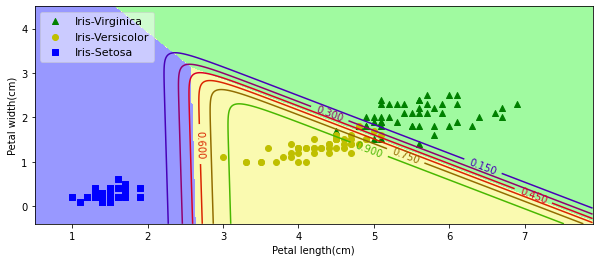

In [11]:
########################
# Now use 2 features and all 3 classes

# petal length, petal width
train_x = iris["data"][:, (2, 3)]
train_y = iris["target"]

# Fit model
parameters = lr.fit(train_x, train_y, lambd=0.1)

# Generate values for petal length and petal width
test_featvec_x0, test_featvec_x1 = jnp.meshgrid(
    jnp.linspace(train_x[:, 0].min() - 0.5, train_x[:, 0].max() + 1, 500),
    jnp.linspace(train_x[:, 1].min() - 0.5, train_x[:, 1].max() + 2, 500),
)

plt.figure(figsize=(10, 4))

# Plot training data
plt.scatter(
    train_x[train_y == 2, 0],
    train_x[train_y == 2, 1],
    c="g",
    marker="^",
    zorder=2,
    label="Iris-Virginica",
)
plt.scatter(
    train_x[train_y == 1, 0],
    train_x[train_y == 1, 1],
    c="y",
    marker="o",
    zorder=2,
    label="Iris-Versicolor",
)
plt.scatter(
    train_x[train_y == 0, 0],
    train_x[train_y == 0, 1],
    c="b",
    marker="s",
    zorder=2,
    label="Iris-Setosa",
)

# Combine new values of petal length, petal width
test_x = jnp.c_[test_featvec_x0.ravel(), test_featvec_x1.ravel()]

# Predict probabilities
y_pred_proba = lr.predict_proba(parameters[0], test_x)
# Make predictions
y_predict = lr.predict(parameters[0], test_x)

# Choose probability for label Iris-Versicolor
prob_iris_versicolor = y_pred_proba[:, 1].reshape(test_featvec_x0.shape)

y_predict = y_predict.reshape(test_featvec_x0.shape)


custom_cmap = ListedColormap(["#9898ff", "#fafab0", "#a0faa0"])
plt.contourf(test_featvec_x0, test_featvec_x1, y_predict, cmap=custom_cmap)
contour = plt.contour(test_featvec_x0, test_featvec_x1, prob_iris_versicolor, cmap=plt.cm.brg)
clb = plt.clabel(contour, inline=1)

plt.xlabel("Petal length(cm)")
plt.ylabel("Petal width(cm)")
plt.legend(loc="upper left", framealpha=0.5, fontsize=11)
# savefig("iris-logreg-2d-3class")
plt.savefig(f"{images_dir}/iris-logreg-2d-3class.png")
plt.show()

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:25: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


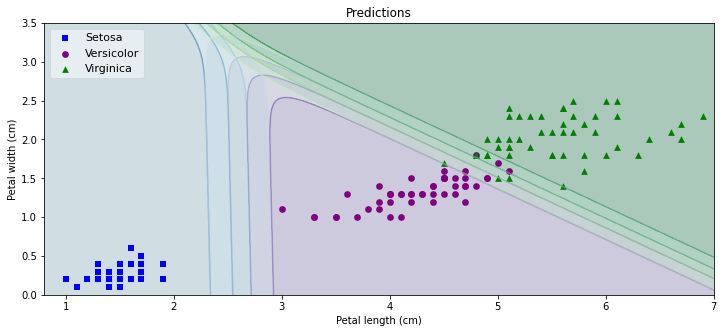

In [12]:
# Fig 2.13 - Use 2 features and all 3 classes

latexify(width_scale_factor=1.55)

# Intialize Plots and other options
if is_latexify_enabled():
    fig = plt.figure()
    SCATTER_SIZE = 10
    legend_fontsize = 5
    line_width = 0.8
else:
    fig = plt.figure(figsize=(12, 5))
    SCATTER_SIZE = 45
    legend_fontsize = 11
    line_width = 1.5

# Get axis of current plot
ax = plt.gca()

# Declare cmaps for countors
cmaps = ["Blues", "Purples", "Greens"]

# Store probabilities for each class
prob_iris_setosa = y_pred_proba[:, 0].reshape(test_featvec_x0.shape)
prob_iris_versicolor = y_pred_proba[:, 1].reshape(test_featvec_x0.shape)
prob_iris_virginica = y_pred_proba[:, 2].reshape(test_featvec_x0.shape)

# Plot countours
plt.contourf(
    test_featvec_x0,
    test_featvec_x1,
    prob_iris_setosa,
    cmap=cmaps[0],
    alpha=0.3,
    levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
)

plt.contour(
    test_featvec_x0,
    test_featvec_x1,
    prob_iris_setosa,
    cmap=cmaps[0],
    alpha=0.4,
    linewidths=line_width,
    levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
)

plt.contourf(
    test_featvec_x0,
    test_featvec_x1,
    prob_iris_versicolor,
    cmap=cmaps[1],
    alpha=0.3,
    levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
)

plt.contour(
    test_featvec_x0,
    test_featvec_x1,
    prob_iris_versicolor,
    cmap=cmaps[1],
    alpha=0.4,
    linewidths=line_width,
    levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
)

plt.contourf(
    test_featvec_x0,
    test_featvec_x1,
    prob_iris_virginica,
    cmap=cmaps[2],
    alpha=0.3,
    levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
)

plt.contour(
    test_featvec_x0,
    test_featvec_x1,
    prob_iris_virginica,
    cmap=cmaps[2],
    alpha=0.4,
    linewidths=line_width,
    levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
)

# Plot training data
plt.scatter(
    train_x[train_y == 0, 0],
    train_x[train_y == 0, 1],
    s=SCATTER_SIZE,
    c="blue",
    marker="s",
    edgecolor="black",
    linewidth=0.01,
    label="Setosa",
)

plt.scatter(
    train_x[train_y == 1, 0],
    train_x[train_y == 1, 1],
    s=SCATTER_SIZE,
    c="purple",
    marker="o",
    edgecolor="black",
    linewidth=0.01,
    label="Versicolor",
)

plt.scatter(
    train_x[train_y == 2, 0],
    train_x[train_y == 2, 1],
    s=SCATTER_SIZE,
    c="green",
    marker="^",
    edgecolor="black",
    linewidth=0.01,
    label="Virginica",
)

# Labels,title and legends for scatter plot
ax.set_xlabel("Petal length (cm)")
ax.set_ylabel("Petal width (cm)")
ax.set_title("Predictions")
ax.set_xlim([0.8, 7])
ax.set_ylim([0, 3.5])
ax.legend(loc="upper left", fontsize=legend_fontsize, framealpha=0.5)

# savefig("iris_logreg_2d")
plt.savefig(f"{images_dir}/iris_logreg_2d.png")

plt.show()

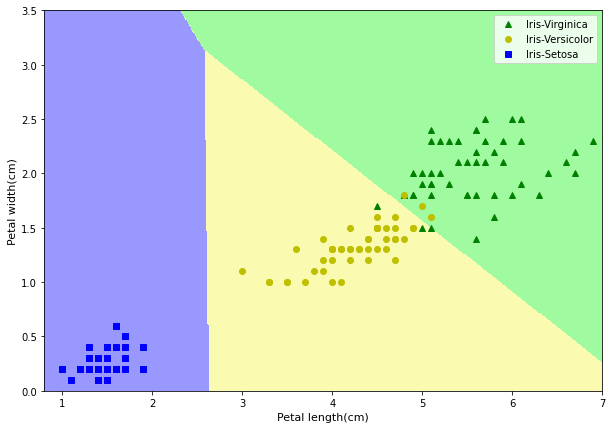

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(train_x[train_y == 2, 0], train_x[train_y == 2, 1], "g^", label="Iris-Virginica")
plt.plot(train_x[train_y == 1, 0], train_x[train_y == 1, 1], "yo", label="Iris-Versicolor")
plt.plot(train_x[train_y == 0, 0], train_x[train_y == 0, 1], "bs", label="Iris-Setosa")

plt.contourf(test_featvec_x0, test_featvec_x1, y_predict, cmap=custom_cmap)
plt.xlabel("Petal length(cm)", fontsize=11)
plt.ylabel("Petal width(cm)", fontsize=11)
plt.legend(loc="upper right")
plt.axis([0.8, 7, 0, 3.5])
# savefig("iris-logreg-2d-3class-noprobs")
plt.savefig(f"{images_dir}/iris-logreg-2d-3class-noprobs.png")

plt.show()

In [14]:
########################
# Fit model and evaluate on separate test set

iris = datasets.load_iris()

# We only take the first two features to make problem harder
data_x = iris.data[:, :2]
data_y = iris.target

# Train Test split
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.33, stratify=data_y, random_state=3)

# Fit models
parameters = lr.fit(x_train, y_train, lambd=0.001)

# Make Predicitons
y_pred = lr.predict(parameters[0], x_test)

# Calculate Errors
errs = y_pred != y_test
count_errs = jnp.sum(errs)
print("Made {} errors out of {}, on instances {}".format(count_errs, len(y_pred), jnp.where(errs)[0]))

# Zero One classification loss
err_rate_test = zero_one_loss(y_test, y_pred)
assert jnp.isclose(err_rate_test, count_errs / len(y_pred))
err_rate_train = zero_one_loss(y_train, lr.predict(parameters[0], x_train))
print("Error rates on train {:0.3f} and test {:0.3f}".format(err_rate_train, err_rate_test))

Made 10 errors out of 50, on instances [ 2  4  5  7 15 25 34 41 45 47]
Error rates on train 0.190 and test 0.200
